In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Configuration
# Real images are 300x300, but we resize to 128x128 for faster training
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Path to your data (Adjust if your folder name is different)
train_dir = 'dataset/casting_data/train/'
test_dir = 'dataset/casting_data/test/'

# 2. Data Generators
# We rescale pixel values from 0-255 to 0-1 (Normalization)
# We also add "Augmentation" to the training data to make the model smarter
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Rotate image slightly
    width_shift_range=0.1,   # Shift left/right
    height_shift_range=0.1,  # Shift up/down
    shear_range=0.1,         # Shear transformation
    zoom_range=0.1,          # Zoom in/out slightly
    horizontal_flip=True,    # Flip image
    fill_mode='nearest'
)

# Test data should NOT be augmented, only rescaled
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the data
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',     # Binary because we have only 2 classes: OK or DEFECT
    color_mode='grayscale'   # The dataset is grayscale
)

print("\nLoading Test Data:")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

# Check class indices (e.g., {'def_front': 0, 'ok_front': 1})
print(f"\nClass Mappings: {train_generator.class_indices}")


Loading Training Data:
Found 6633 images belonging to 2 classes.

Loading Test Data:
Found 715 images belonging to 2 classes.

Class Mappings: {'def_front': 0, 'ok_front': 1}


Displaying sample images from the training set...


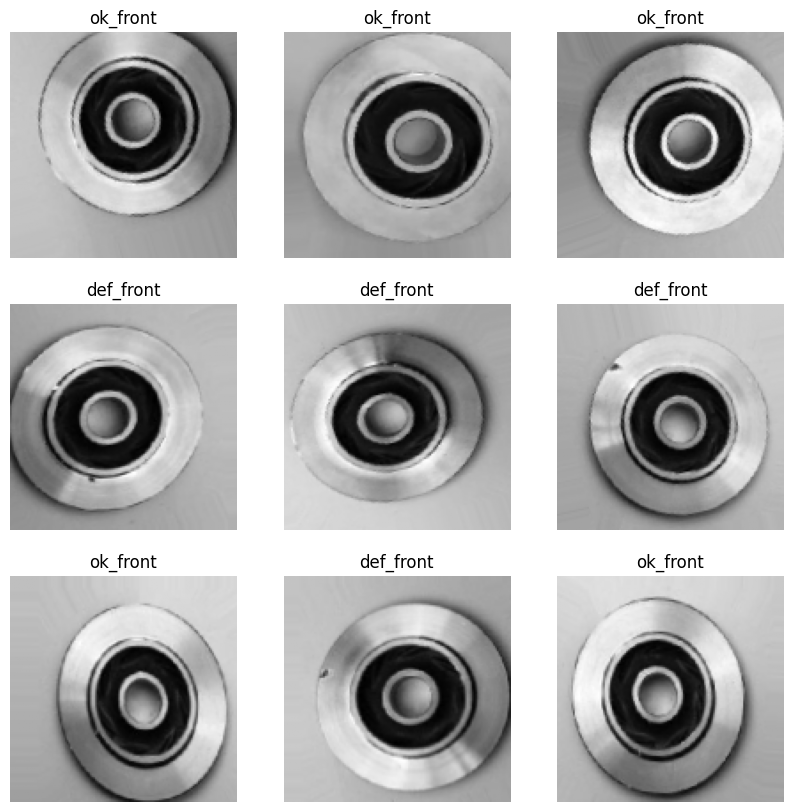

In [2]:
# Function to plot images
def plot_sample_images(generator):
    # Get a batch of images and labels
    images, labels = next(generator)
    
    # Map 0 and 1 back to names
    class_dict = {v: k for k, v in generator.class_indices.items()}
    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Reshape (128,128,1) to (128,128) for plotting
        image_to_show = images[i].reshape(IMG_HEIGHT, IMG_WIDTH)
        plt.imshow(image_to_show, cmap='gray')
        plt.title(class_dict[int(labels[i])])
        plt.axis('off')
    plt.show()

print("Displaying sample images from the training set...")
plot_sample_images(train_generator)

In [3]:
model = Sequential([
    # Layer 1: Convolution
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(2, 2),
    
    # Layer 2: Convolution
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Layer 3: Convolution
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flattening
    Flatten(),
    
    # Fully Connected Layer
    Dense(128, activation='relu'),
    Dropout(0.5), # Drops 50% of neurons randomly to prevent overfitting
    
    # Output Layer
    # Sigmoid is used for binary classification (Output is probability 0 to 1)
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\houss\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Define callbacks (Optional but recommended)
# Stop training if accuracy doesn't improve for 3 epochs (saves time)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("\nStarting Training...")
history = model.fit(
    train_generator,
    epochs=15,             # We will try for 15 loops
    validation_data=test_generator,
    callbacks=[early_stop]
)
print("Training Finished!")


Starting Training...
Epoch 1/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 85s 401ms/step - accuracy: 0.5809 - loss: 0.6766 - val_accuracy: 0.7315 - val_loss: 0.5144
Epoch 2/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.7567 - loss: 0.5086 - val_accuracy: 0.8531 - val_loss: 0.3610
Epoch 3/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.8244 - loss: 0.3931 - val_accuracy: 0.7930 - val_loss: 0.5269
Epoch 4/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.8648 - loss: 0.3075 - val_accuracy: 0.8867 - val_loss: 0.2555
Epoch 5/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.9038 - loss: 0.2244 - val_accuracy: 0.7399 - val_loss: 0.7319
Epoch 6/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.9044 - loss: 0.2244 - val_accuracy: 0.8182 - val_loss: 0.3556
Epoch 7/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.9267 - loss: 0.1748 - val_accuracy: 0.8084 - val_loss: 0.4824
Training Finished!


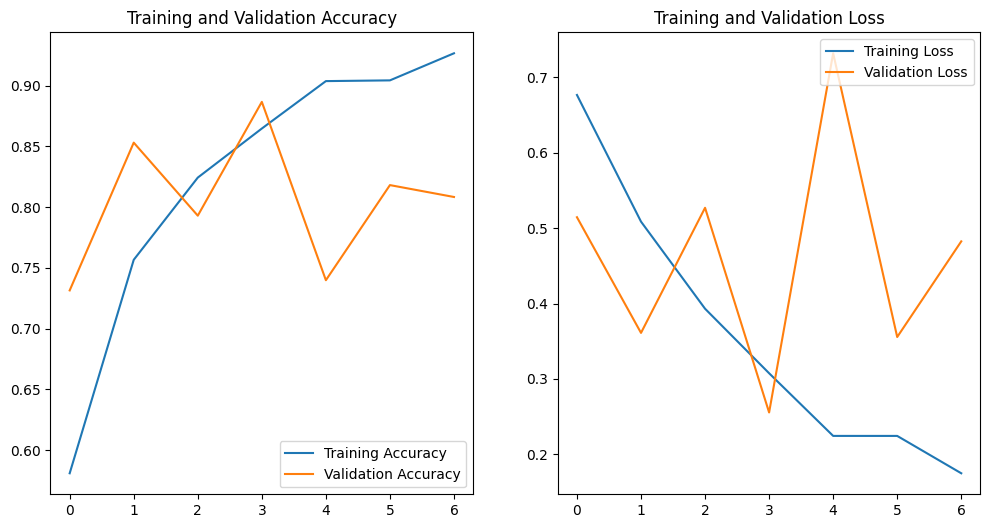


Evaluating on Test Set:
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8084 - loss: 0.4824
Final Test Accuracy: 80.84%


In [5]:
# 1. Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2. Final Evaluation on Test Set
print("\nEvaluating on Test Set:")
loss, accuracy = model.evaluate(test_generator)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")